In [11]:
import pandas as pd
import numpy as np
import math
import pickle

from scipy import stats
import scipy.io
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
from scipy.io import loadmat


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from src import SMOTE
from src import CFS
from src import metrices_V2 as metrices

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# Data Load and other util function

In [82]:
def load_data(project):
    understand_path = 'data/understand_files_all/' + project + '_understand.csv'
    commit_guru_path = 'data/commit_guru/' + project + '.csv'
    understand_df = pd.read_csv(understand_path)
    understand_df = understand_df.dropna(axis = 1,how='all')
    cols_list = understand_df.columns.values.tolist()
    for item in ['Kind', 'Name','commit_hash', 'Bugs']:
        if item in cols_list:
            cols_list.remove(item)
            cols_list.insert(0,item)
    understand_df = understand_df[cols_list]
    commit_guru_df = pd.read_csv(commit_guru_path)
    cols = understand_df.columns.tolist()
    
    commit_guru_df = commit_guru_df.drop(labels = ['parent_hashes','author_name','author_name',
                                                   'author_email','fileschanged','author_date',
                                                   'author_date_unix_timestamp', 'commit_message',
                                                  'classification', 'fix', 'contains_bug','fixes',],axis=1)

#     understand_df = understand_df.drop_duplicates(cols[4:len(cols)])
    df = understand_df.merge(commit_guru_df,on='commit_hash')
    cols = df.columns.tolist()
    cols = cols[1:] + [cols[0]]
    df = df[cols]
    for item in ['Kind','commit_hash']:
        if item in cols:
            df = df.drop(labels = [item],axis=1)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def load_both_data(project,metric):
    understand_path = 'data/understand_files_all/' + project + '_understand.csv'
    understand_df = pd.read_csv(understand_path)
    understand_df = understand_df.dropna(axis = 1,how='all')
    cols_list = understand_df.columns.values.tolist()
    for item in ['Kind', 'Name','commit_hash', 'Bugs']:
        if item in cols_list:
            cols_list.remove(item)
            cols_list.insert(0,item)
    understand_df = understand_df[cols_list]
    cols = understand_df.columns.tolist()
    understand_df = understand_df.drop_duplicates(cols[4:len(cols)])
    understand_df['Name'] = understand_df.Name.str.rsplit('.',1).str[1]
    
    commit_guru_file_level_path = 'data/commit_guru_file/' + project + '.csv'
    commit_guru_file_level_df = pd.read_csv(commit_guru_file_level_path)
    commit_guru_file_level_df['commit_hash'] = commit_guru_file_level_df.commit_hash.str.strip('"')
    commit_guru_file_level_df = commit_guru_file_level_df[commit_guru_file_level_df['file_name'].str.contains('.java')]
    commit_guru_file_level_df['Name'] = commit_guru_file_level_df.file_name.str.rsplit('/',1).str[1].str.split('.').str[0].str.replace('/','.')
    commit_guru_file_level_df = commit_guru_file_level_df.drop('file_name',axis = 1)
    
    
    df = understand_df.merge(commit_guru_file_level_df,how='left',on=['commit_hash','Name'])
    
    
    cols = df.columns.tolist()
    cols.remove('Bugs')
    cols.append('Bugs')
    df = df[cols]
    file_names = df.Name
    
    for item in ['Kind', 'Name','commit_hash']:
        if item in cols:
            df = df.drop(labels = [item],axis=1)
#     df.dropna(inplace=True)
    df = df.drop_duplicates()
    df.reset_index(drop=True, inplace=True)
    
    y = df.Bugs
    X = df.drop('Bugs',axis = 1)
    cols = X.columns
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X,columns = cols)
    imp_mean = IterativeImputer(random_state=0)
    X = imp_mean.fit_transform(X)
    X = pd.DataFrame(X,columns = cols)
    
    if metric == 'process':
        X = X[['file_la', 'file_ld', 'file_lt', 'file_age', 'file_ddev',
       'file_nuc', 'own', 'minor', 'file_ndev', 'file_ncomm', 'file_adev',
       'file_nadev', 'file_avg_nddev', 'file_avg_nadev', 'file_avg_ncomm',
       'file_ns', 'file_exp', 'file_sexp', 'file_rexp', 'file_nd', 'file_sctr']]
    elif metric == 'product':
        X = X.drop(['file_la', 'file_ld', 'file_lt', 'file_age', 'file_ddev',
       'file_nuc', 'own', 'minor', 'file_ndev', 'file_ncomm', 'file_adev',
       'file_nadev', 'file_avg_nddev', 'file_avg_nadev', 'file_avg_ncomm',
       'file_ns', 'file_exp', 'file_sexp', 'file_rexp', 'file_nd', 'file_sctr'],axis = 1)
    else:
        X = X
    X['Name'] = file_names
    X['Bugs'] = y
    
    return X

def load_data_release_level(project,metric):
    understand_path = 'data/understand_files_all/' + project + '_understand.csv'
    understand_df = pd.read_csv(understand_path)
    understand_df = understand_df.dropna(axis = 1,how='all')
    cols_list = understand_df.columns.values.tolist()
    for item in ['Kind', 'Name','commit_hash', 'Bugs']:
        if item in cols_list:
            cols_list.remove(item)
            cols_list.insert(0,item)
    understand_df = understand_df[cols_list]
    cols = understand_df.columns.tolist()
    understand_df = understand_df.drop_duplicates(cols[4:len(cols)])
    understand_df['Name'] = understand_df.Name.str.rsplit('.',1).str[1]
    
    commit_guru_file_level_path = 'data/commit_guru_file/' + project + '.csv'
    commit_guru_file_level_df = pd.read_csv(commit_guru_file_level_path)
    commit_guru_file_level_df['commit_hash'] = commit_guru_file_level_df.commit_hash.str.strip('"')
    commit_guru_file_level_df = commit_guru_file_level_df[commit_guru_file_level_df['file_name'].str.contains('.java')]
    commit_guru_file_level_df['Name'] = commit_guru_file_level_df.file_name.str.rsplit('/',1).str[1].str.split('.').str[0].str.replace('/','.')
    commit_guru_file_level_df = commit_guru_file_level_df.drop('file_name',axis = 1)
    
    release_df = pd.read_pickle('data/release/' + project + '_release.pkl')
    release_df = release_df.sort_values('created_at',ascending=False)
    release_df = release_df.reset_index(drop=True)
    release_df['created_at'] = pd.to_datetime(release_df.created_at)
    release_df['created_at'] = release_df.created_at.dt.date
    
    commit_guru_path = 'data/commit_guru/' + project + '.csv' 
    commit_guru_df = pd.read_csv(commit_guru_path)
    cols = understand_df.columns.tolist()
    commit_guru_df['created_at'] = pd.to_datetime(commit_guru_df.author_date_unix_timestamp,unit='s')
    commit_guru_df['created_at'] = commit_guru_df.created_at.dt.date
    
    commit_guru_df = commit_guru_df[['commit_hash','created_at']]
    
    df = understand_df.merge(commit_guru_file_level_df,how='left',on=['commit_hash','Name'])
    df = df.merge(commit_guru_df,how='left',on=['commit_hash'])


    
    cols = df.columns.tolist()
    cols.remove('Bugs')
    cols.append('Bugs')
    df = df[cols]
    file_names = df.Name
    commit_hash = df.commit_hash
    for item in ['Kind', 'Name','commit_hash']:
        if item in cols:
            df = df.drop(labels = [item],axis=1)
    df = df.drop_duplicates()
    df.reset_index(drop=True, inplace=True)
    
    created_at = df.created_at
    df = df.drop('created_at',axis = 1)
    y = df.Bugs
    X = df.drop('Bugs',axis = 1)
    cols = X.columns
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X,columns = cols)
    imp_mean = IterativeImputer(random_state=0)
    X = imp_mean.fit_transform(X)
    X = pd.DataFrame(X,columns = cols)
    X['created_at'] = created_at
    
    if metric == 'process':
        X = X[['file_la', 'file_ld', 'file_lt', 'file_age', 'file_ddev',
       'file_nuc', 'own', 'minor', 'file_ndev', 'file_ncomm', 'file_adev',
       'file_nadev', 'file_avg_nddev', 'file_avg_nadev', 'file_avg_ncomm',
       'file_ns', 'file_exp', 'file_sexp', 'file_rexp', 'file_nd', 'file_sctr','created_at']]
    elif metric == 'product':
        X = X.drop(['file_la', 'file_ld', 'file_lt', 'file_age', 'file_ddev',
       'file_nuc', 'own', 'minor', 'file_ndev', 'file_ncomm', 'file_adev',
       'file_nadev', 'file_avg_nddev', 'file_avg_nadev', 'file_avg_ncomm',
       'file_ns', 'file_exp', 'file_sexp', 'file_rexp', 'file_nd', 'file_sctr'],axis = 1)
    else:
        X = X
    
    df = X
    df['Name'] = file_names
    df['Bugs'] = y
    
    accepted_commit_dates = []
    for i in range(release_df.shape[0]-1):
        sub_df = df[df['created_at'] <= release_df.loc[i,'created_at']]
        sub_df = sub_df[sub_df['created_at'] > release_df.loc[i+1,'created_at']]
        if len(sub_df.created_at.unique()) > 0:
            last_release = sub_df.created_at.unique()[0]
            for unq_release in sub_df.created_at.unique():
                if unq_release > last_release:
                    last_release = unq_release
            accepted_commit_dates.append(last_release)
#             print(sub_df.created_at.unique(),last_release)
            
    df = df[df.created_at.isin(accepted_commit_dates)]
    
    df = df.drop('created_at',axis = 1)
    
    return df

def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def apply_cfs(df):
        y = df.Bugs.values
        X = df.drop(labels = ['Bugs'],axis = 1)
        X = X.values
        selected_cols = CFS.cfs(X,y)
        cols = df.columns[[selected_cols]].tolist()
        cols.append('Bugs')
        return df[cols],cols

def get_spearmanr(df):
    df = df.drop('Bugs',axis = 1)
    file_corr = []
    for name in df.Name.unique():
        sub_df = df[df['Name'] == name]
        if sub_df.shape[0] < 2:
            continue
        sub_df = sub_df.drop('Name',axis = 1)
        rho, pval = stats.spearmanr(sub_df.values,sub_df.values,axis = 1)
        file_corr.append(np.median(rho[:,:int(len(rho)/2)]))
    return file_corr

# Getting List of projects

In [91]:
proj_df = pd.read_csv('projects.csv')
projects = proj_df.repo_name.tolist()
metric = 'process+product'

# Run the experiment

In [92]:
project_corr = {}
for project in projects[151:]:
    try:
        if project == '.DS_Store':
            continue
#         if project != 'Pokemap':
#             continue
        print("+++++++++++++++++   "  + project + "  +++++++++++++++++")
        df = load_data_release_level(project,metric)
        corr = get_spearmanr(df)
        project_corr[project] = corr
        print(np.median(corr))
    except Exception as e:
        print(e)
        continue
with open('results/Performance/process+product_corr_release.pkl', 'wb') as handle:
    pickle.dump(project_corr, handle, protocol=pickle.HIGHEST_PROTOCOL)

+++++++++++++++++   environment-dashboard  +++++++++++++++++
0.9133247848485231
+++++++++++++++++   plantuml  +++++++++++++++++
0.9982755254042619
+++++++++++++++++   egads  +++++++++++++++++
nan
+++++++++++++++++   dockerfile-maven  +++++++++++++++++
0.9832334430155226
+++++++++++++++++   android-pdfview  +++++++++++++++++
0.8458757522557849
+++++++++++++++++   rebound  +++++++++++++++++
0.8973852708414856
+++++++++++++++++   react-native-background-timer  +++++++++++++++++
0.7220407642168067
+++++++++++++++++   android-rss  +++++++++++++++++
nan
+++++++++++++++++   logback-kafka-appender  +++++++++++++++++
0.7872010892503533
+++++++++++++++++   Droppy  +++++++++++++++++
0.7433930274803109
+++++++++++++++++   RxActivityResult  +++++++++++++++++
0.8863102157135958
+++++++++++++++++   smart-show  +++++++++++++++++
0.957755650819871
+++++++++++++++++   PatternLock  +++++++++++++++++
0.9567317562822755
+++++++++++++++++   RxHttpUtils  +++++++++++++++++
0.932336836435072
+++++++++++++++++ 

nan
+++++++++++++++++   the-app  +++++++++++++++++
nan
+++++++++++++++++   glide-transformations  +++++++++++++++++
0.7981263553148477
+++++++++++++++++   X2C  +++++++++++++++++
nan
+++++++++++++++++   Android-DirectoryChooser  +++++++++++++++++
0.927197757893086
+++++++++++++++++   jdeferred  +++++++++++++++++
0.9083063466644303
+++++++++++++++++   RxBluetooth  +++++++++++++++++
0.9740789799222092
+++++++++++++++++   react-native-calendar-events  +++++++++++++++++
nan
+++++++++++++++++   cordova-plugin-admob-free  +++++++++++++++++
0.9697714345908371
+++++++++++++++++   sofa-tracer  +++++++++++++++++
0.9071267978320345
+++++++++++++++++   react-native-touch-id  +++++++++++++++++
0.8586657056771685
+++++++++++++++++   linuxdeploy  +++++++++++++++++
0.9067560339701517
+++++++++++++++++   brickhouse  +++++++++++++++++
nan
+++++++++++++++++   FinestWebView-Android  +++++++++++++++++
0.9211634201602303
+++++++++++++++++   tut-spring-boot-oauth2  +++++++++++++++++
nan
+++++++++++++++++   an

0.9026520434524945
+++++++++++++++++   droid-fu  +++++++++++++++++
nan
+++++++++++++++++   react-native-picker  +++++++++++++++++
0.9196769384287709
+++++++++++++++++   DebugDrawer  +++++++++++++++++
0.9775646442453947
+++++++++++++++++   android_packages_apps_UnifiedNlp  +++++++++++++++++
0.920430255022986
+++++++++++++++++   walt  +++++++++++++++++
0.954384446783178
+++++++++++++++++   problem  +++++++++++++++++
0.838670101717216
+++++++++++++++++   SpringCloud  +++++++++++++++++
nan
+++++++++++++++++   jira-client  +++++++++++++++++
0.9519422765003517
+++++++++++++++++   Hive-JSON-Serde  +++++++++++++++++
0.9066854544399005
+++++++++++++++++   react-native-google-signin  +++++++++++++++++
0.7917894123167426
+++++++++++++++++   socket.io-client-java  +++++++++++++++++
0.9371879989741221
+++++++++++++++++   DroidPlugin  +++++++++++++++++
nan
+++++++++++++++++   TagMo  +++++++++++++++++
0.9704890140144757
+++++++++++++++++   android-transition  +++++++++++++++++
0.914345477221196
+++++

0.9538652889440765
+++++++++++++++++   libsuperuser  +++++++++++++++++
nan
+++++++++++++++++   dubbo-admin  +++++++++++++++++
nan
+++++++++++++++++   cardslib  +++++++++++++++++
Shape of passed values is (1598, 45), indices imply (1598, 66)
+++++++++++++++++   EvalEx  +++++++++++++++++
0.9978336129813307
+++++++++++++++++   react-native-music-control  +++++++++++++++++
0.9212175172945494
+++++++++++++++++   gradle-download-task  +++++++++++++++++
0.9000994837997391
+++++++++++++++++   apk-parser  +++++++++++++++++
0.9027775140016832
+++++++++++++++++   sendgrid-java  +++++++++++++++++
0.7876910263506901
+++++++++++++++++   Caldroid  +++++++++++++++++
0.8964168264637091
+++++++++++++++++   google-authenticator  +++++++++++++++++
nan
+++++++++++++++++   VasSonic  +++++++++++++++++
0.9721250350437836
+++++++++++++++++   jInstagram  +++++++++++++++++
0.9296321797445285
+++++++++++++++++   Emoji  +++++++++++++++++
Shape of passed values is (500, 45), indices imply (500, 66)
++++++++++++++++

Shape of passed values is (486, 45), indices imply (486, 66)
+++++++++++++++++   EdXposed  +++++++++++++++++
0.9238613921941863
+++++++++++++++++   apis  +++++++++++++++++
0.9763099279886942
+++++++++++++++++   camerakit-android  +++++++++++++++++
0.9249219390653332
+++++++++++++++++   Koloboke  +++++++++++++++++
nan
+++++++++++++++++   pf4j  +++++++++++++++++
No columns to parse from file
+++++++++++++++++   kafka-connect-hdfs  +++++++++++++++++
0.9327144432249876
+++++++++++++++++   AlgoDS  +++++++++++++++++
nan
+++++++++++++++++   Store  +++++++++++++++++
0.9073253325773705
+++++++++++++++++   moshi  +++++++++++++++++
0.9424101909019169
+++++++++++++++++   EventBus  +++++++++++++++++
0.9451193206745543
+++++++++++++++++   jOOL  +++++++++++++++++
0.9180928248833721
+++++++++++++++++   gdx-ai  +++++++++++++++++
0.9528157078912212
+++++++++++++++++   jaeger-client-java  +++++++++++++++++
0.9315670116467968
+++++++++++++++++   DeepLinkDispatch  +++++++++++++++++
0.9388739775199815
+++++

Shape of passed values is (1265, 45), indices imply (1265, 66)
+++++++++++++++++   jade4j  +++++++++++++++++
0.9428186770588027
+++++++++++++++++   griffin  +++++++++++++++++
0.9149530418080234
+++++++++++++++++   robospice  +++++++++++++++++
0.9954413333054516
+++++++++++++++++   TonY  +++++++++++++++++
0.9347990899184726
+++++++++++++++++   shimmer  +++++++++++++++++
0.9760356550868491
+++++++++++++++++   owner  +++++++++++++++++
0.9169180385611375
+++++++++++++++++   asynchbase  +++++++++++++++++
0.970635699508587
+++++++++++++++++   abixen-platform  +++++++++++++++++
nan
+++++++++++++++++   simple-stack  +++++++++++++++++
0.9069300686483746
+++++++++++++++++   tilesfx  +++++++++++++++++
0.959837671817359
+++++++++++++++++   Rosie  +++++++++++++++++
0.9017545328049683
+++++++++++++++++   andOTP  +++++++++++++++++
0.9399071817126856
+++++++++++++++++   gumtree  +++++++++++++++++
0.9978000401508289
+++++++++++++++++   hackerskeyboard  +++++++++++++++++
Shape of passed values is (884, 

0.9562006815366778
+++++++++++++++++   s3proxy  +++++++++++++++++
0.9132276001297849
+++++++++++++++++   metacat  +++++++++++++++++
0.9109150828342081
+++++++++++++++++   J2ME-Loader  +++++++++++++++++
0.9232483455616631
+++++++++++++++++   react-native-iap  +++++++++++++++++
0.917814605392475
+++++++++++++++++   leshan  +++++++++++++++++
0.9464559601243123
+++++++++++++++++   cucumber-reporting  +++++++++++++++++
0.9435004773365481
+++++++++++++++++   unfolding  +++++++++++++++++
0.9351162351030677
+++++++++++++++++   redis-manager  +++++++++++++++++
0.9256395819760557
+++++++++++++++++   java-driver  +++++++++++++++++
0.9700957221150703
+++++++++++++++++   tx-lcn  +++++++++++++++++
0.9589350901001588
+++++++++++++++++   SecurityShepherd  +++++++++++++++++
Shape of passed values is (1918, 45), indices imply (1918, 66)
+++++++++++++++++   subclipse  +++++++++++++++++
nan
+++++++++++++++++   couchdb-lucene  +++++++++++++++++
0.9648768077965333
+++++++++++++++++   programming  ++++++++++

0.9083818751791469
+++++++++++++++++   astyanax  +++++++++++++++++
0.9503685093615585
+++++++++++++++++   javacpp  +++++++++++++++++
Shape of passed values is (1221, 45), indices imply (1221, 66)
+++++++++++++++++   XChart  +++++++++++++++++
0.956815447231333
+++++++++++++++++   cucumber  +++++++++++++++++
0.9766740678374839
+++++++++++++++++   maps  +++++++++++++++++
0.9602928640112884
+++++++++++++++++   stripe-java  +++++++++++++++++
0.9223062365203853
+++++++++++++++++   HoloEverywhere  +++++++++++++++++
Shape of passed values is (4105, 45), indices imply (4105, 66)
+++++++++++++++++   RSyntaxTextArea  +++++++++++++++++
0.9543081146329778
+++++++++++++++++   facebook-android-sdk  +++++++++++++++++
0.9205401181016737
+++++++++++++++++   malmo  +++++++++++++++++
0.9916972932389965
+++++++++++++++++   GCViewer  +++++++++++++++++
0.9211597050415133
+++++++++++++++++   lucida  +++++++++++++++++
Shape of passed values is (1064, 45), indices imply (1064, 66)
+++++++++++++++++   handlebars

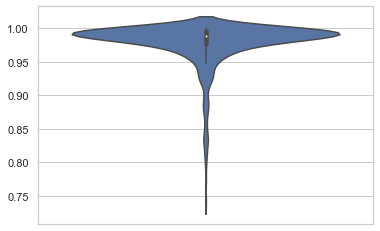

In [187]:
project_corr = pd.read_pickle('results/Performance/Correlations/product_corr_release.pkl')
# flat_list = [item for sublist in list(project_corr.values()) for item in sublist]
flat_list = [np.median(sublist) for sublist in list(project_corr.values())]
ax = sns.violinplot(y=flat_list)
plt.savefig('results/Performance/Correlations/product_corr_release.pdf')

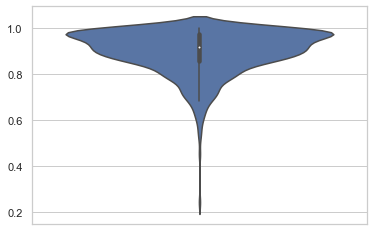

In [189]:
project_corr = pd.read_pickle('results/Performance/Correlations/process_corr_release.pkl')
# flat_list = [item for sublist in list(project_corr.values()) for item in sublist]
flat_list = [np.nanmedian(sublist) for sublist in list(project_corr.values())]
ax = sns.violinplot(y=flat_list)
plt.savefig('results/Performance/Correlations/process_corr_release.pdf')

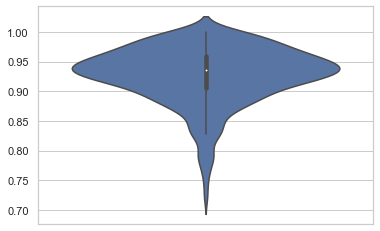

In [151]:
project_corr = pd.read_pickle('results/Performance/Correlations/process+product_corr_release.pkl')
# flat_list = [item for sublist in list(project_corr.values()) for item in sublist]
flat_list = [np.nanmedian(sublist) for sublist in list(project_corr.values())]
ax = sns.violinplot(y=flat_list,scale = 'count')
plt.savefig('results/Performance/Correlations/process+product_corr_release.pdf')

In [199]:
metrics = ['process','product','process+product']
final_df = pd.DataFrame()
for metric in metrics:
    project_corr = pd.read_pickle('results/Performance/Correlations/' + metric + '_corr_release.pkl')
    flat_list = [np.nanmedian(sublist) for sublist in list(project_corr.values())]
    project_corr_df = pd.DataFrame(flat_list, columns = ['scores'])
    project_corr_df['metrics'] = [metric]*project_corr_df.shape[0]
    final_df = pd.concat([final_df,project_corr_df], axis = 0)
final_df = final_df.dropna()

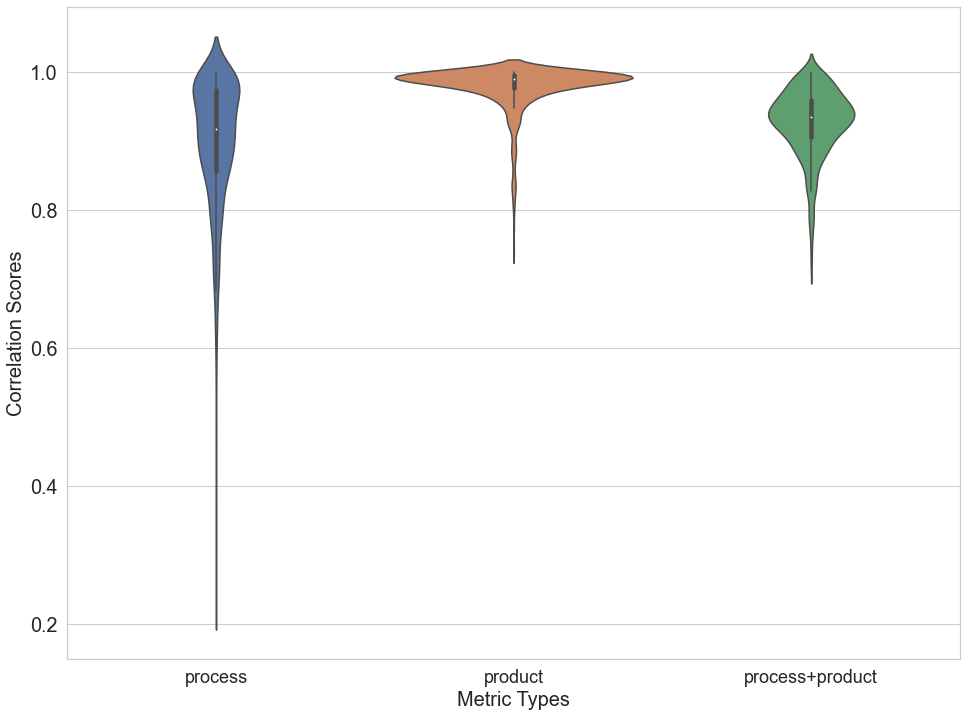

In [200]:
sns.set(style='whitegrid',font_scale=1.8)
fig_dims = (16, 12)
fig, ax = plt.subplots(figsize=fig_dims)
order = metrics
g = sns.violinplot(x="metrics", y="scores",margin_titles=True,kind="box", scale = 'area',
                   inner = 'box',
                   order=order, data=final_df)
plt.xlabel('Metric Types', fontsize=20)
plt.ylabel('Correlation Scores', fontsize=20)
ax.set_xticklabels(metrics, rotation=0, fontsize=18)
# ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], rotation=0, fontsize=18)
plt.savefig('results/Performance/Correlations/corr.png')

In [195]:
final_df

,scores,metrics
0,0.692618,process
1,0.956465,process
2,0.981806,process
3,0.960721,process
4,0.896325,process
...,...,...
40,0.940191,process+product
41,0.975143,process+product
42,0.900852,process+product
43,0.987432,process+product
